In [20]:
import warnings
warnings.simplefilter("ignore")

import os
os.chdir('/content/drive/MyDrive/interview-nba5years')
os.listdir('.')

['resources', 'eda.ipynb', 'model.ipynb', 'mod_selec.ipynb']

# Import

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

# Global variables & Utils

In [23]:
# Variables
pathdata = "./resources/nba_logreg.csv"

# Decided in explo_data.ipynb
    ## Features & Target
features_selected = ['GP', 'TOV', 'STL', 'OREB'] # Anova features only
target = 'TARGET_5Yrs'

    ## Metrics
metrics = ['recall', 'precision', 'F1_score', 'accuracy']

# Composed by the process in the previous explo_data.ipynb
def cleaner_data(data, target):
    # Duplicated?
    data = data.drop_duplicates()
    
    # Mislabeled ?
    idx_mislabeled = []
    all_features = list(data.columns)
    all_features.remove(target)
    for name, df in data.groupby(all_features):
        if df.shape[0] > 1:
            #print(df) #If you want to see the mislabeled
            idx_mislabeled.extend(list(df.index))
            
    data = data.drop(idx_mislabeled)
    data.reset_index(inplace=True, drop=True)
    
    return data

# Load data & Split
- 80% / 20%
- X_train / Y_train
- X_test / Y_test
- Precision score on if it is worth to invest in the player (more than 5 years)

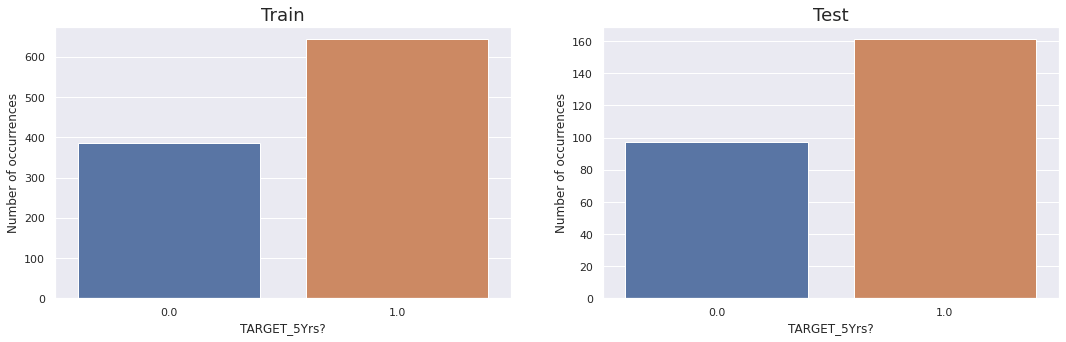

In [24]:
# Load data
data = pd.read_csv(pathdata)
data = cleaner_data(data, target)

# Start split
train_idx, test_idx = train_test_split(range(data.shape[0]), test_size=0.20, random_state=3, stratify=data[target])

X_train, Y_train = data.loc[train_idx, features_selected], data.loc[train_idx, target]
X_test, Y_test = data.loc[test_idx, features_selected], data.loc[test_idx, target]

# Show occurencies
fig = plt.figure(figsize=(18,5))

### Target variable exploration TRAIN
ax = sns.countplot(Y_train, ax=plt.subplot(121));
plt.xlabel('TARGET_5Yrs?');
plt.ylabel('Number of occurrences');
# Adding Sub Title (One for a each figure)
ax.set_title('Train', fontsize=18)

### Target variable exploration TEST
ax = sns.countplot(Y_test, ax=plt.subplot(122));
plt.xlabel('TARGET_5Yrs?');
plt.ylabel('Number of occurrences');
# Adding Sub Title (One for a each figure)
ax.set_title('Test', fontsize=18)
plt.show()

#### [COMMENT]

Nicely stratified 80% / 20% data split done

# Normlization & Good Type for training

In [25]:
scale_mod = StandardScaler().fit(X_train)
pkl.dump(scale_mod, open('./resources/models/scaler.pkl', 'wb'))

print('Mean row :', scale_mod.mean_)
print('Mean stdvar :', scale_mod.scale_)

X_train_ok = scale_mod.transform(X_train)
X_test_ok = scale_mod.transform(X_test)

Y_train_ok = Y_train.values
Y_test_ok = Y_test.values

print('X_train_ok :', type(X_train_ok))
print('X_test_ok :', type(X_test_ok))
print('Y_train_ok :', type(Y_train_ok))
print('Y_test_ok :', type(Y_test_ok))

Mean row : [60.38737864  1.19679612  0.61757282  1.00708738]
Mean stdvar : [17.67205121  0.73107145  0.40910977  0.77431978]
X_train_ok : <class 'numpy.ndarray'>
X_test_ok : <class 'numpy.ndarray'>
Y_train_ok : <class 'numpy.ndarray'>
Y_test_ok : <class 'numpy.ndarray'>


# Model definition

- Logistic regression
- Random forest classifier (rfc)
- Keras DNN (Dense Neuronal Network)

### LogReg

In [40]:
# Metrics Scikit-learn format
def sk_metrics(probs, y_true):
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    
    # Get threshold maximazing f1s
    f1s = precisions + recalls
    idx_threshold_f1s = np.argmax(f1s)
    threshold_f1s = thresholds[idx_threshold_f1s]
    y_pred = np.where(probs >= threshold_f1s, 1, 0)

    """
    # BAD! 😣 Because the model will only try to have precision=1.0 and recall~0.0
    # Get threshold maximazing the precision
    idx_threshold_precisions = np.argmax(precisions)
    threshold_precisions = thresholds[idx_threshold_precisions]
    y_pred = np.where(probs >= threshold_precisions, 1, 0)
    """

    # Get recall and precision
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return [recall, precision, f1, accuracy]

# Predict with a sk_classifier
def pred_prob(sk_mod, X):
    #Spec : Assuming your target is (0,1), then the classifier would output a probability
    #matrix of dimension (N,2). The first index refers to the probability that the data belong to class 0,
    #and the second refers to the probability that the data belong to class 1.
    list_y = sk_mod.predict_proba(X)
    return np.transpose(np.array(list_y)[:,1])

In [41]:
def get_logreg():
    
    model = LogisticRegression(random_state=3, n_jobs=-1)
    
    return model

# define a function to fit the model
def fit_and_evaluate_logreg(t_x, t_y, val_x, val_y):
    model = None
    model = get_logreg()
    model.fit(t_x,t_y)
    pred_y = pred_prob(model, val_x)
    val_score = sk_metrics(pred_y, val_y)
    print("Val Score: ", val_score)
    return val_score

### Rfc

In [42]:
def get_rfc():
    
    model = RandomForestClassifier(random_state=3, n_jobs=-1)
    
    return model

# define a function to fit the model
def fit_and_evaluate_rfc(t_x, t_y, val_x, val_y):
    model = None
    model = get_rfc()
    model.fit(t_x,t_y)
    pred_y = pred_prob(model, val_x)
    val_score = sk_metrics(pred_y, val_y)
    print("Val Score: ", val_score)
    return val_score

### Keras DNN

In [43]:
# Folder stock dnn keras fold
dnn_nba_folder = './resources/models/tmp_dnn_nba_foldX'

In [44]:
# Metrics Keras Format
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # Optimum theorical threshold on DNN for 0.5
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # Optimum theorical threshold on DNN for 0.5
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [45]:
def get_dnn():
    
    input_mod = Input((len(features_selected)))
    layer_mod = Dense(len(features_selected), activation='relu')(input_mod)
    layer_mod = Dense(4, activation='relu')(layer_mod)
    output_mod = Dense(1, activation = 'sigmoid')(layer_mod)
    
    model = Model(inputs=input_mod, outputs=output_mod)
    
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(opt_adam, loss='binary_crossentropy', metrics=[recall_m, precision_m, f1_m, 'accuracy'])
    
    return model

#define a function to fit the model
def fit_and_evaluate_keras(t_x, t_y, val_x, val_y, no_fold, EPOCHS=200, BATCH_SIZE=128):
    
    #set early stopping criteria
    pat = 5 #this is the number of epochs with no improvment after which the training will stop
    early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=0)

    #define the model checkpoint callback -> this will keep on saving the model as a physical file
    dnn_path = dnn_nba_folder + '/dnn_nba_fold' + str(no_fold) + '.h5'
    model_checkpoint = ModelCheckpoint(dnn_path, verbose=0, save_best_only=True)
    
    #get model architecture and train
    model = None
    model = get_dnn()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=0, validation_data=(val_x, val_y))
    
    #evaluate best model
    model.load_weights(dnn_path)
    val_score = model.evaluate(val_x, val_y, verbose=0, batch_size=val_y.shape[0]) #batch_size=32 by default if not specified
    val_score.pop(0) # Remove val_loss
    print("Val Score: ", val_score)
    
    return results, val_score

# Cross-validation & Model selection
- 3-FoldStratified for each model
- GridSearchCV can be done for optimizing the model parameters. But we are going to use default parameters for simplicity

In [47]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)

cmpt_fold = 0
print(' '*19 + 'Train | Val')
for train_index, val_index in skf.split(X_train_ok, Y_train):
    print('Elements in Fold ' + str(cmpt_fold) + ' :', train_index.shape[0], '|', val_index.shape[0])
    cmpt_fold += 1

                   Train | Val
Elements in Fold 0 : 686 | 344
Elements in Fold 1 : 687 | 343
Elements in Fold 2 : 687 | 343


In [48]:
#save the model history in a list after fitting so that we can plot later
logreg_scores = []
rfc_scores = []
dnn_scores = []

cmpt_fold = 0
for train_index, val_index in skf.split(X_train_ok, Y_train_ok):
    print("Training on Fold ", cmpt_fold)
    t_x, t_y = X_train_ok[train_index], Y_train_ok[train_index]
    val_x, val_y = X_train_ok[val_index], Y_train_ok[val_index]
    
    # LogReg
    print('\nLogReg log')
    print("======="*12)
    val_score = fit_and_evaluate_logreg(t_x, t_y, val_x, val_y)
    logreg_scores.append(val_score)
    print("======="*12, end="\n")
    
    # Rfc
    print('\nRfc log')
    print("======="*12)
    val_score = fit_and_evaluate_rfc(t_x, t_y, val_x, val_y)
    rfc_scores.append(val_score)
    print("======="*12, end="\n")
    
    # Keras DNN
    print('\nKeras DNN log')
    print("======="*12)
    _, val_score = fit_and_evaluate_keras(t_x, t_y, val_x, val_y, cmpt_fold)
    dnn_scores.append(val_score)
    print("======="*12, end="\n\n\n")
    
    cmpt_fold += 1

Training on Fold  0

LogReg log
Val Score:  [0.9813953488372092, 0.6677215189873418, 0.7947269303201506, 0.6831395348837209]

Rfc log
Val Score:  [1.0, 0.6268221574344023, 0.7706093189964158, 0.627906976744186]

Keras DNN log
Val Score:  [0.8279069662094116, 0.7416666746139526, 0.7824175357818604, 0.7122092843055725]


Training on Fold  1

LogReg log
Val Score:  [0.9813084112149533, 0.6687898089171974, 0.7954545454545454, 0.685131195335277]

Rfc log
Val Score:  [1.0, 0.6239067055393586, 0.7684021543985637, 0.6239067055393586]

Keras DNN log
Val Score:  [0.7616822719573975, 0.7546296119689941, 0.758139431476593, 0.6967930197715759]


Training on Fold  2

LogReg log
Val Score:  [0.9345794392523364, 0.6968641114982579, 0.7984031936127743, 0.7055393586005831]

Rfc log
Val Score:  [0.985981308411215, 0.6393939393939394, 0.7757352941176471, 0.6443148688046647]

Keras DNN log
Val Score:  [0.7196261882781982, 0.7586206793785095, 0.7386090755462646, 0.6822157502174377]




In [49]:
logreg_scores_array = np.array(logreg_scores)
rfc_scores_array = np.array(rfc_scores)
dnn_scores_array = np.array(dnn_scores)
scores_array = np.dstack((logreg_scores_array, rfc_scores_array, dnn_scores_array))
#1d: fold
#2d: metric_type
#3d: model

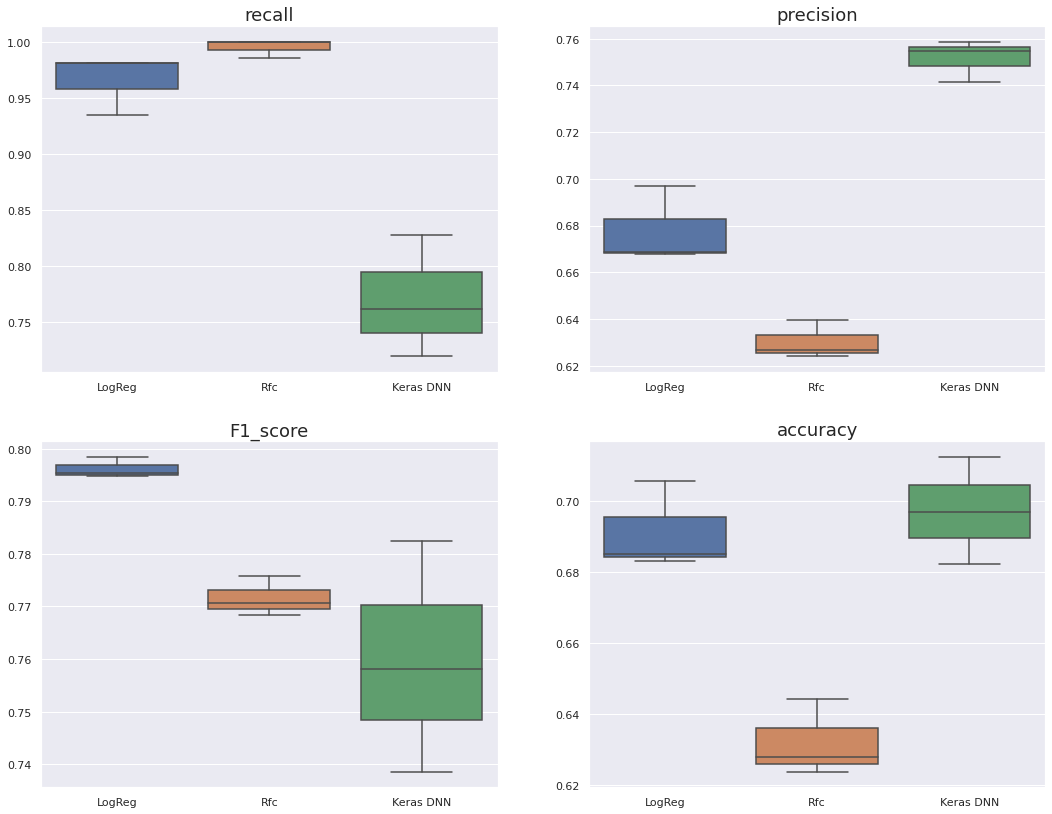

In [50]:
# Figure initiation
fig, axs = plt.subplots(2, 2, figsize=(18,14))

for k in range(len(metrics)):
    
    metric_name = metrics[k]
    df_metric = pd.DataFrame(scores_array[:,k,:], columns=['LogReg', 'Rfc', 'Keras DNN'])
    
    ax_current = axs[k//2,k%2]
    ax_current.set_title(metric_name, fontsize=18)
    
    ### Boxplot of Column per Selected / Not Selected Value
    sns.boxplot(data=df_metric, ax=ax_current);

# Printing Chart
plt.show()

#### [COMMENT]
Model performance summary
- With a Recall to 1 and a Precision really bad -> The model is only predicting 1 by default
- Seems like what is happening with the LogReg & Rfc
- No surprise with the features we have
- 🎉 Best precision with Keras DNN
- CCL : So going to use Keras DNN

# Decision on which fold model to choose

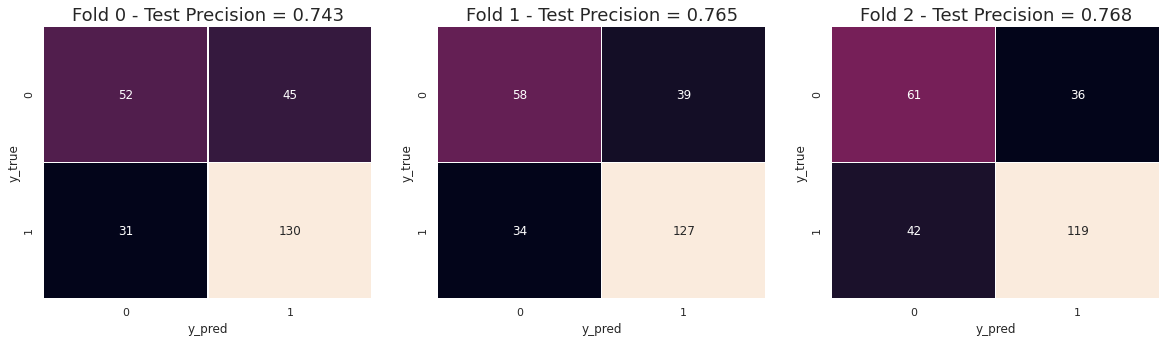

In [51]:
best_mod = None
best_precision = -1
fig, axs = plt.subplots(1, 3, figsize=(20,5))
cpt_ax = 0

for dnn_name in os.listdir(dnn_nba_folder):
    
    dnn_mod = get_dnn()
    dnn_mod.load_weights(dnn_nba_folder + '/' + dnn_name)
    pred_y = dnn_mod.predict(X_test_ok)
    pred_y = np.round(pred_y)

    precision = precision_score(Y_test_ok, pred_y)
    if best_precision < precision:
        best_mod = dnn_mod
        best_precision = precision
    
    #print('Precision score on test :', precision)
    cm = confusion_matrix(Y_test_ok, pred_y)

    sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="white",fmt=".0f",ax=axs[cpt_ax], cbar=False)
    axs[cpt_ax].set_title('Fold ' + str(cpt_ax) + ' - Test Precision = ' + "{:.3f}".format(precision), fontsize=18)
    axs[cpt_ax].set_xlabel("y_pred")
    axs[cpt_ax].set_ylabel("y_true")
    
    cpt_ax += 1
    
plt.show()

#### [COMMENT]

- CCL : The Keras DNN fold 2 will be used

In [52]:
best_mod.save('./resources/models/dnn_nba.h5')

# Conclusion on the model

In [53]:
print('- Going to use : Keras DNN')
print('- Cross-Validated Precision score of :', dnn_scores_array[:,2].mean(), '∓', dnn_scores_array[:,2].std())
dnn_path_best = './resources/models/dnn_nba.h5'
print('- Best Saved at :', dnn_path_best)

best_mod = get_dnn()
best_mod.load_weights(dnn_path_best)
pred_y = best_mod.predict(X_test_ok)
pred_y = np.round(pred_y)
precision = precision_score(Y_test_ok, pred_y)

print('- Test Precision score :', precision)

- Going to use : Keras DNN
- Cross-Validated Precision score of : 0.7597220142682394 ∓ 0.01791970467153879
- Best Saved at : ./resources/models/dnn_nba.h5
- Test Precision score : 0.7677419354838709


#### [COMMENT]

- NEXT : Deploy the keras model as REST API